In [1]:
# import environment
from marketsai.mon_policy.env_mon_fin_dictob import MonPolicyFinite

# from marketsai.mon_policy.env_mon_policy_colab import MonPolicyColab

# import ray
from ray import tune, shutdown, init
from ray.tune.registry import register_env

# from ray.tune.integration.mlflow import MLflowLoggerCallback

# For custom metrics (Callbacks)
from scipy.stats import linregress
from ray.rllib.agents.callbacks import DefaultCallbacks
from scipy.stats import linregress
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import PPOTrainer

# common imports
from typing import Dict
import numpy as np
import seaborn as sn
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import json
import math
import random

# import logging
# import random
# import math

""" STEP 0: Experiment configs """


DATE = "Nov28_"
ENV_LABEL = "mon_fin_0"
OBS_IDSHOCK = False
INFL_REGIME = "low"
NATIVE = False
TEST = True
RUN_TRAINING = True
RUN_ANALYSIS = True
# in case there is no training
INFO_ANALYSIS = "/Users/matiascovarrubias/Dropbox/RL_macro/Tests/expINFO_native_mon_fin_exp_0_Nov1_PPO_test.json"
SAVE_EXP_INFO = True
SAVE_PROGRESS = True
PLOT_PROGRESS = True
sn.color_palette("Set2")

if TEST:
    if NATIVE:
        OUTPUT_PATH_EXPERS = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
        )
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results/ALL/"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/ALL/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/ALL/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/ALL/"

else:
    if NATIVE:
        OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/"

ALGO = "PPO"  # either PPO" or "SAC"
if NATIVE:
    device = "native_"  # either "native" or "server"
else:
    device = "server_"

n_firms_LIST = [2]  # list with number of agents for each run
n_inds_LIST = [200]
ITERS_TEST = 100  # number of iteration for test
ITERS_RUN = 2000  # number of iteration for fullrun


# Other economic Hiperparameteres.
ENV_HORIZON = 12 * 5
EVAL_HORIZON = 12 * 5
BETA = 0.95 ** (1 / 12)  # discount parameter

# Analysis options
PLOT_HIST = True
EVAL_RESULTS = True
NO_FLEX_HORIZON = 36
CHKPT_SELECT_REF = True
RESULTS_REF = np.array([1.32, 1.24, 0.12, 0.08, 0.009])
CHKPT_SELECT_MANUAL = False
CHKPT_id = 0
CHKPT_SELECT_MIN = False
CHKPT_SELECT_MAX = False
""" STEP 1: Paralleliztion and batch options"""
# Parallelization options
NUM_CPUS = 40
NUM_CPUS_DRIVER = 1
NUM_TRIALS = 40
NUM_PAR_TRIALS = 40
NUM_ROLLOUT = ENV_HORIZON * 1
NUM_ENV_PW = 1  # num_env_per_worker
NUM_GPUS = 0
BATCH_ROLLOUT = 1
NUM_MINI_BATCH = NUM_CPUS_DRIVER

N_WORKERS = (NUM_CPUS - NUM_PAR_TRIALS * NUM_CPUS_DRIVER) // NUM_PAR_TRIALS
BATCH_SIZE = NUM_ROLLOUT * (max(N_WORKERS, 1)) * NUM_ENV_PW * BATCH_ROLLOUT

print("number of workers:", N_WORKERS, "batch size:", BATCH_SIZE)

# define length of experiment (MAX_STEPS) and experiment name
if TEST == True:
    MAX_STEPS = ITERS_TEST * BATCH_SIZE
else:
    MAX_STEPS = ITERS_RUN * BATCH_SIZE

# checkpointing, evaluation during trainging and stopage
CHKPT_FREQ = 1000
if TEST:
    EVAL_INTERVAL = ITERS_TEST
    EVAL_EPISODES = 10
    SIMUL_EPISODES = 10
else:
    EVAL_INTERVAL = ITERS_RUN
    EVAL_EPISODES = 50
    SIMUL_EPISODES = 50

STOP = {"timesteps_total": MAX_STEPS}

# Initialize ray
shutdown()
init(
    num_cpus=NUM_CPUS+7,
    num_gpus=NUM_GPUS,
    log_to_driver=False,
)
# global configss
register_env(ENV_LABEL, MonPolicyFinite)

""" STEP 2: set custom metrics such as discounted rewards to keep track of through leraning"""
# Define custom metrics using the Callbacks class
# See rllib documentation on Callbacks. They are a way of inserting code in different parts of the pipeline.

# function to get discounted rewards for analysys
def process_rewards(r):
    """Compute discounted reward from a vector of rewards."""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).

        assert episode.length == 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        episode.user_data["rewards"] = []
        episode.user_data["markup_ij_avge"] = []
        episode.user_data["freq_p_adj"] = []
        episode.user_data["size_adj"] = []
        episode.user_data["log_c"] = []
        episode.user_data["profits"] = []

    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        if episode.length > 1:  # at t=0, previous rewards are not defined
            episode.user_data["rewards"].append(episode.prev_reward_for(0))

            episode.user_data["markup_ij_avge"].append(
                episode.last_info_for(0)["mean_mu_ij"]
            )
            episode.user_data["freq_p_adj"].append(
                episode.last_info_for(0)["move_freq"]
            )
            episode.user_data["size_adj"].append(
                episode.last_info_for(0)["mean_p_change"]
            )
            episode.user_data["log_c"].append(episode.last_info_for(0)["log_c"])
            episode.user_data["profits"].append(
                episode.last_info_for(0)["mean_profits"]
            )

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        episode.custom_metrics["discounted_rewards"] = process_rewards(
            episode.user_data["rewards"][:-NO_FLEX_HORIZON]
        )

        episode.custom_metrics["mean_markup_ij"] = np.mean(
            episode.user_data["markup_ij_avge"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["freq_p_adj"] = np.mean(
            episode.user_data["freq_p_adj"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["size_adj"] = np.mean(
            episode.user_data["size_adj"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["std_log_c"] = np.std(
            episode.user_data["log_c"][:-NO_FLEX_HORIZON]
        )
        episode.custom_metrics["profits"] = np.mean(
            episode.user_data["profits"][:-NO_FLEX_HORIZON]
        )

        episode.custom_metrics["mean_markup_ij_final"] = np.mean(
            episode.user_data["markup_ij_avge"][-12:]
        )


""" STEP 3: Environment and Algorithm configuration """

# environment config including evaluation environment (without exploration)
env_config = {
    "horizon": ENV_HORIZON,
    "n_inds": n_inds_LIST[0],
    "n_firms": n_firms_LIST[0],
    # "eval_mode": False,
    # "random_eval": True,
    # "analysis_mode": False,
    "noagg": False,
    "obs_flex_index": True,
    "obs_idshock": OBS_IDSHOCK,
    "infl_regime": INFL_REGIME,
    # "infl_regime_scale": [3, 1.3, 2],
    # "seed_eval": 10000,
    # "seed_analisys": 3000,
    # "markup_min": 1,
    # "markup_max": 2,
    # "markup_star": 1.3,
    # "final_stage": 12,
    # "rew_mean": 0,
    # "rew_std": 1,
    # "parameters": {
    #     "beta": 0.95 ** (1 / 12),
    #     "log_g_bar": 0.0021,
    #     "rho_g": 0.61,
    #     "sigma_g": 0.0019,
    #     "theta": 1.5,
    #     "eta": 10.5,
    #     "menu_cost": 0.17,
    #     "sigma_z": 0.038,
    # },
}


env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_eval["horizon"] = EVAL_HORIZON

# we instantiate the environment to extrac relevant info
" CHANGE HERE "
env = MonPolicyFinite(env_config)

# common configuration

"""
NOTE: in order to do hyperparameter optimization, you can select a range of values 
with tune.choice([0.05,1] for random choice or tune.grid_search([0.05,1]) for fix search.
# see https://docs.ray.io/en/master/tune/key-concepts.html#search-spaces for spaces and their definition.
# se at the bottom (Annex_env_hyp) for an explanation how to do the same with environment parameters.
"""
common_config = {
    # CUSTOM METRICS
    "callbacks": MyCallbacks,
    # ENVIRONMENT
    "gamma": BETA,
    "env": ENV_LABEL,
    "env_config": env_config,
    "horizon": ENV_HORIZON,
    # MODEL
    "framework": "torch",
    # "model": tune.grid_search([{"use_lstm": True}, {"use_lstm": False}]),
    # TRAINING CONFIG
    "num_workers": N_WORKERS,
    "create_env_on_driver": False,
    "num_gpus": NUM_GPUS / NUM_PAR_TRIALS,
    "num_envs_per_worker": NUM_ENV_PW,
    "num_cpus_for_driver": NUM_CPUS_DRIVER,
    "rollout_fragment_length": NUM_ROLLOUT,
    "train_batch_size": BATCH_SIZE,
    # EVALUATION
    "evaluation_interval": EVAL_INTERVAL,
    "evaluation_num_episodes": EVAL_EPISODES,
    "evaluation_config": {
        "explore": False,
        "env_config": env_config_eval,
    },
    # MULTIAGENT,
    "multiagent": {
        "policies": {
            "firm_even": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
            "firm_odd": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
        },
        "policy_mapping_fn": (
            lambda agent_id: "firm_even" if agent_id % 2 == 0 else "firm_odd"
        ),
        # "replay_mode": "independent",  # you can change to "lockstep".
        # OTHERS
    },
}

# Configs specific to the chosel algorithms, INCLUDING THE LEARNING RATE
ppo_config = {
    # "lr": 0.0001,
    "lr_schedule": [[0, 0.00005], [MAX_STEPS/2, 0.00001]],
    "sgd_minibatch_size": BATCH_SIZE // NUM_MINI_BATCH,
    "num_sgd_iter": 1,
    "batch_mode": "complete_episodes",
    # "lambda": 0.98,
    # "entropy_coeff": 0,
    # "kl_coeff": 0.2,
    # "vf_loss_coeff": 0.5,
    "vf_clip_param": float("inf"),
    # "entropy_coeff_schedule": [[0, 0.01], [5120 * 1000, 0]],
    "clip_param": 0.15,
    "clip_actions": True,
}

sac_config = {"prioritized_replay": False, "normalize_actions": False}

if ALGO == "PPO":
    training_config = {**common_config, **ppo_config}
elif ALGO == "SAC":
    training_config = {**common_config, **sac_config}
else:
    training_config = common_config

/scratch/mc5851/.env/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


number of workers: 0 batch size: 60


2021-11-28 16:15:13,159	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
/scratch/mc5851/.env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
""" STEP 4: run training """

if RUN_TRAINING:
    exp_names = []
    trial_logdirs = []
    exp_dirs = []
    checkpoints = []
    configs = []
    learning_dta = []

    rewards_eval = []
    mu_ij_eval = []
    mu_ij_final_eval = []
    freq_p_adj_eval = []
    size_adj_eval = []
    std_log_c_eval = []
    profits_eval = []

    rewards = []
    mu_ij = []
    mu_ij_final = []
    freq_p_adj = []
    size_adj = []
    std_log_c = []
    profits = []

    # RUN TRAINER
    env_configs = []

    for ind, n_firms in enumerate(n_firms_LIST):
        EXP_LABEL = device + ENV_LABEL + f"_exp_{ind}_"
        if TEST == True:
            EXP_NAME = EXP_LABEL + DATE + ALGO + "_test"
        else:
            EXP_NAME = EXP_LABEL + DATE + ALGO + "_run"

        env_config["n_firms"] = n_firms
        env_config_eval["n_firms"] = n_firms

        """ CHANGE HERE """
        env = MonPolicyFinite(env_config)
        training_config["env_config"] = env_config
        training_config["evaluation_config"]["env_config"] = env_config_eval
        training_config["multiagent"] = {
            "policies": {
                "firm_even": (
                    None,
                    env.observation_space[0],
                    env.action_space[0],
                    {},
                ),
                "firm_odd": (
                    None,
                    env.observation_space[0],
                    env.action_space[0],
                    {},
                ),
            },
            "policy_mapping_fn": (
                lambda agent_id: "firm_even" if agent_id % 2 == 0 else "firm_odd"
            ),
        }

        analysis = tune.run(
            ALGO,
            name=EXP_NAME,
            config=training_config,
            stop=STOP,
            checkpoint_freq=CHKPT_FREQ,
            checkpoint_at_end=True,
            # metric="evaluation/custom_metrics/discounted_rewards_mean",
            # metric="custom_metrics/discounted_rewards_mean",
            # mode="max",
            num_samples=NUM_TRIALS,
            local_dir=OUTPUT_PATH_RESULTS,
            verbose=1,
            # resources_per_trial={"gpu": 0.5},
        )

        rewards_eval.append(
            [
                list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                    "discounted_rewards_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        mu_ij_eval.append(
            [
                list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                    "mean_markup_ij_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        mu_ij_final_eval.append(
            [
                list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                    "mean_markup_ij_final_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        freq_p_adj_eval.append(
            [
                list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                    "freq_p_adj_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        size_adj_eval.append(
            [
                list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                    "size_adj_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )

        std_log_c_eval.append(
            [
                list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                    "std_log_c_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )

        profits_eval.append(
            [
                list(analysis.results.values())[i]["custom_metrics"]["profits_mean"]
                for i in range(NUM_TRIALS)
            ]
        )
        rewards.append(
            [
                list(analysis.results.values())[i]["custom_metrics"][
                    "discounted_rewards_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        mu_ij.append(
            [
                list(analysis.results.values())[i]["custom_metrics"][
                    "mean_markup_ij_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        mu_ij_final.append(
            [
                list(analysis.results.values())[i]["custom_metrics"][
                    "mean_markup_ij_final_mean"
                ]
                for i in range(NUM_TRIALS)
            ]
        )
        freq_p_adj.append(
            [
                list(analysis.results.values())[i]["custom_metrics"]["freq_p_adj_mean"]
                for i in range(NUM_TRIALS)
            ]
        )
        size_adj.append(
            [
                list(analysis.results.values())[i]["custom_metrics"]["size_adj_mean"]
                for i in range(NUM_TRIALS)
            ]
        )

        std_log_c.append(
            [
                list(analysis.results.values())[i]["custom_metrics"]["std_log_c_mean"]
                for i in range(NUM_TRIALS)
            ]
        )

        profits.append(
            [
                list(analysis.results.values())[i]["custom_metrics"]["profits_mean"]
                for i in range(NUM_TRIALS)
            ]
        )
        exp_names.append(EXP_NAME)
        exp_dirs.append(analysis._experiment_dir)
        trial_logdirs.append([analysis.trials[i].logdir for i in range(NUM_TRIALS)])
        configs.append(
            [
                {
                    "env_config": analysis.trials[i].config["env_config"],
                    # "lr": analysis.trials[i].config["lr"],
                    "lr_schedule": analysis.trials[i].config["lr_schedule"],
                }
                for i in range(NUM_TRIALS)
            ]
        )
        checkpoints.append(
            [analysis.trials[i].checkpoint.value for i in range(NUM_TRIALS)]
        )

        # learning_dta.append(
        #     analysis.best_dataframe[
        #         ["episodes_total", "evaluation/custom_metrics/discounted_rewards_mean"]
        #     ]
        # )
        if SAVE_PROGRESS:
            learning_dta.append(
                [
                    list(analysis.trial_dataframes.values())[i][
                        [
                            # "episodes_total",
                            "custom_metrics/discounted_rewards_mean",
                            "custom_metrics/mean_markup_ij_mean",
                            "custom_metrics/mean_markup_ij_final_mean",
                            "custom_metrics/freq_p_adj_mean",
                            "custom_metrics/size_adj_mean",
                            "custom_metrics/std_log_c_mean",
                            "custom_metrics/profits_mean",
                        ]
                    ]
                    for i in range(NUM_TRIALS)
                ]
            )
            for i in range(NUM_TRIALS):
                learning_dta[ind][i].columns = [
                    # "episodes_total",
                    f"discounted_rewards_trial_{i}",
                    f"mu_ij_trial_{i}",
                    f"mu_ij_final_trial_{i}",
                    f"freq_p_adj_trial_{i}",
                    f"size_adj_trial_{i}",
                    f"std_log_c_trial_{i}",
                    f"profits_trial_{i}",
                ]
                # learning_dta[ind][i].set_index("episodes_total")
            pd.concat(learning_dta[ind], axis=1).to_csv(
                OUTPUT_PATH_EXPERS + "progress_" + exp_names[ind] + ".csv"
            )


2021-11-28 16:37:43,383	INFO tune.py:549 -- Total run time: 1348.00 seconds (1340.99 seconds for the tuning loop).


mu_ij [[1.3345692482181157, 1.3116200592856997, 1.3316297171866522, 1.3319894355207413, 1.3214646060462005, 1.3211695497363292, 1.315103339006449, 1.322244330977594, 1.318159555006772, 1.320668771404764, 1.3240691502887985, 1.3027094941112964, 1.3107925965094753, 1.316514981485515, 1.3296241502016337, 1.3170213356061051, 1.3234526070650539, 1.3130294586627378, 1.3085508711064755, 1.3199484919759887, 1.3046063883021584, 1.3094096148482042, 1.3106880450544063, 1.3234924963910577, 1.306741231770281, 1.3063787157188653, 1.3090559142429798, 1.3161974300560697, 1.3131031171377754, 1.3221312678774781, 1.306426090787634, 1.3181146201974174, 1.3277890387900455, 1.3308515000894512, 1.31250976993048, 1.3105580320888477, 1.3085778535871568, 1.3413747917993246, 1.3202124251129002, 1.3182252948113447]] 
 mu_ij_final [[1.26260239730527, 1.2327304454899082, 1.2480904418335608, 1.2636841304814443, 1.2571855816089856, 1.2510387680536756, 1.246666468337799, 1.250615399571446, 1.2448495930607122, 1.261784

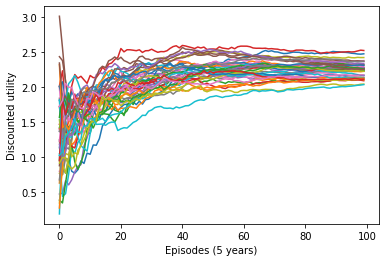

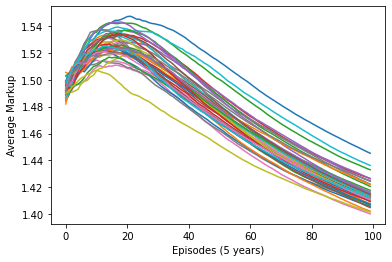

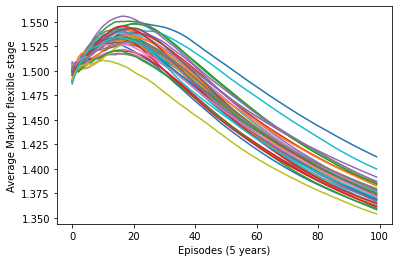

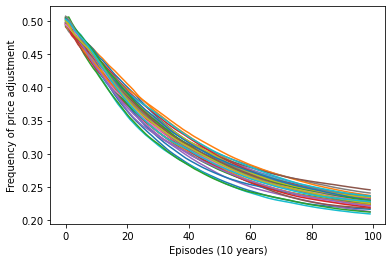

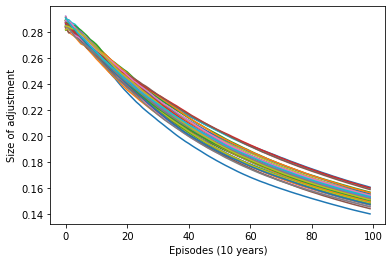

In [3]:
""" Organize and Plot multi firm expers """

# global experiment name
if len(exp_names) > 1:
    EXP_LABEL = device + f"_multiexp_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_test_" + DATE + ALGO
    else:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_run_" + DATE + ALGO

# create CSV with information on each experiment
if SAVE_EXP_INFO:

    exp_dict = {
        "n_agents": n_firms_LIST,
        "exp_names": exp_names,
        "exp_dirs": exp_dirs,
        "trial_dirs": trial_logdirs,
        "checkpoints": checkpoints,
        "configs": configs,
        "results_eval": [
            rewards_eval,
            mu_ij_eval,
            mu_ij_final_eval,
            freq_p_adj_eval,
            size_adj_eval,
            std_log_c_eval,
            profits_eval,
        ],
        "results": [
            rewards,
            mu_ij,
            mu_ij_final,
            freq_p_adj,
            size_adj,
            std_log_c,
            profits,
        ],
    }

    print(
        "mu_ij",
        mu_ij_eval,
        "\n",
        "mu_ij_final",
        mu_ij_final_eval,
        "\n",
        "freq_p_adj:",
        freq_p_adj_eval,
        "\n",
        "size_adj",
        size_adj_eval,
        "\n",
        "std_log_c:",
        std_log_c_eval,
    )

    with open(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json", "w+") as f:
        json.dump(exp_dict, f)

    # exp_df = pd.DataFrame(exp_dict)
    # exp_df.to_csv(OUTPUT_PATH_EXPERS + "exp_info" + EXP_NAME + ".csv")
    print(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json")

# Plot and save progress
if PLOT_PROGRESS:
    for ind, n_firms in enumerate(n_firms_LIST):
        for i in range(NUM_TRIALS):
            learning_plot = sn.lineplot(
                data=learning_dta[ind][i],
                y=f"discounted_rewards_trial_{i}",
                x=learning_dta[ind][i].index,
            )
        learning_plot = learning_plot.get_figure()
        plt.ylabel("Discounted utility")
        plt.xlabel("Episodes (5 years)")
        # plt.legend(labels=[f"trial {i}" for i in range(NUM_TRIALS)])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_rewards" + exp_names[ind] + ".png"
        )
        plt.show()
        plt.close()

        for i in range(NUM_TRIALS):
            learning_plot = sn.lineplot(
                data=learning_dta[ind][i],
                y=f"mu_ij_trial_{i}",
                x=learning_dta[ind][i].index,
            )
        learning_plot = learning_plot.get_figure()
        plt.ylabel("Average Markup")
        plt.xlabel("Episodes (5 years)")
        # plt.legend(labels=[f"trial {i}" for i in range(NUM_TRIALS)])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_mu_ij" + exp_names[ind] + ".png"
        )
        plt.show()
        plt.close()

        for i in range(NUM_TRIALS):
            learning_plot = sn.lineplot(
                data=learning_dta[ind][i],
                y=f"mu_ij_final_trial_{i}",
                x=learning_dta[ind][i].index,
            )
        learning_plot = learning_plot.get_figure()
        plt.ylabel("Average Markup flexible stage")
        plt.xlabel("Episodes (5 years)")
        # plt.legend(labels=[f"trial {i}" for i in range(NUM_TRIALS)])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_mu_ij_final" + exp_names[ind] + ".png"
        )
        plt.show()
        plt.close()

        for i in range(NUM_TRIALS):
            learning_plot = sn.lineplot(
                data=learning_dta[ind][i],
                y=f"freq_p_adj_trial_{i}",
                x=learning_dta[ind][i].index,
            )
        learning_plot = learning_plot.get_figure()
        plt.ylabel("Frequency of price adjustment")
        plt.xlabel("Episodes (10 years)")
        # plt.legend(labels=[f"trial {i}" for i in range(NUM_TRIALS)])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_freq_p_adj" + exp_names[ind] + ".png"
        )
        plt.show()
        plt.close()

        for i in range(NUM_TRIALS):
            learning_plot = sn.lineplot(
                data=learning_dta[ind][i],
                y=f"size_adj_trial_{i}",
                x=learning_dta[ind][i].index,
            )
        learning_plot = learning_plot.get_figure()
        plt.ylabel("Size of adjustment")
        plt.xlabel("Episodes (10 years)")
        # plt.legend(labels=[f"trial {i}" for i in range(NUM_TRIALS)])
        learning_plot.savefig(
            OUTPUT_PATH_FIGURES + "progress_size_adj" + exp_names[ind] + ".png"
        )
        plt.show()
        plt.close()